## * * * `Project-3` :- `Sentiment Analysis of Real-time Flipkart Product Reviews` * * *

In [1]:
### Load the required libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import re

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
%%time
import nltk
nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm, tqdm_notebook
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import joblib
from joblib import Memory
import os

import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
from sentence_transformers import SentenceTransformer, util

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91994\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Wall time: 12.9 s


In [3]:
### To read the useful csv file into DataFrame

df = pd.read_csv(r"reviews_badminton.csv")

In [4]:
df

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [6]:
df.shape

(8518, 8)

In [7]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

In [8]:
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [9]:
mode_review_text = df.groupby('Ratings')['Review text'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_title = df.groupby('Ratings')['Review Title'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_up_votes = df.groupby('Ratings')['Up Votes'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_down_votes = df.groupby('Ratings')['Down Votes'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_reviewer_name = df.groupby('Ratings')['Reviewer Name'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_place_of_review = df.groupby('Ratings')['Place of Review'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_month = df.groupby('Ratings')['Month'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

In [10]:
mode_review_text

,Ratings,Review text
0,1,Not goodREAD MORE
1,2,Quality is not goodREAD MORE
2,3,GoodREAD MORE
3,4,GoodREAD MORE
4,5,GoodREAD MORE


In [11]:
mode_review_title

,Ratings,Review Title
0,1,Did not meet expectations
1,2,Not good
2,3,Wonderful
3,4,Wonderful
4,5,Wonderful


In [12]:
mode_review_up_votes

,Ratings,Up Votes
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [13]:
mode_review_down_votes

,Ratings,Down Votes
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [14]:
mode_reviewer_name

,Ratings,Reviewer Name
0,1,Flipkart Customer
1,2,Flipkart Customer
2,3,Flipkart Customer
3,4,Flipkart Customer
4,5,Flipkart Customer


In [15]:
mode_place_of_review

,Ratings,Place of Review
0,1,"Certified Buyer, Bengaluru"
1,2,"Certified Buyer, Chennai"
2,3,"Certified Buyer, Bengaluru"
3,4,"Certified Buyer, Chennai"
4,5,"Certified Buyer, Bengaluru"


In [16]:
mode_review_month

,Ratings,Month
0,1,Dec 2018
1,2,Nov 2020
2,3,Oct 2020
3,4,Jul 2020
4,5,Oct 2020


In [17]:
dfs = [mode_reviewer_name, mode_review_title, mode_place_of_review, mode_review_up_votes, mode_review_down_votes, mode_review_month, mode_review_text]

In [18]:
from functools import reduce
new = reduce(lambda  left,right: pd.merge(left,right,on=['Ratings'], how='outer'), dfs)

In [19]:
new

,Ratings,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text
0,1,Flipkart Customer,Did not meet expectations,"Certified Buyer, Bengaluru",0.0,0.0,Dec 2018,Not goodREAD MORE
1,2,Flipkart Customer,Not good,"Certified Buyer, Chennai",0.0,0.0,Nov 2020,Quality is not goodREAD MORE
2,3,Flipkart Customer,Wonderful,"Certified Buyer, Bengaluru",0.0,0.0,Oct 2020,GoodREAD MORE
3,4,Flipkart Customer,Wonderful,"Certified Buyer, Chennai",0.0,0.0,Jul 2020,GoodREAD MORE
4,5,Flipkart Customer,Wonderful,"Certified Buyer, Bengaluru",0.0,0.0,Oct 2020,GoodREAD MORE


In [20]:
df = df.set_index('Ratings')
new = new.set_index('Ratings')

In [21]:
df1 = df.combine_first(new).reset_index()

In [22]:
df1

,Ratings,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text
0,1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...
1,1,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...
2,1,ASHIK P A,Over priced,"Certified Buyer, Bengaluru",147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...
3,1,Hashim A,Did not meet expectations,"Certified Buyer, Panoor",22.0,5.0,Mar 2021,This is the second time i am getting an opened...
4,1,Harish R,I think it is duplicate,"Certified Buyer, Bangalore",81.0,35.0,Feb 2018,I usually buy them the same model but this did...
...,...,...,...,...,...,...,...,...
8513,5,Jayachandra,High cost,"Certified Buyer, Mangalore",0.0,0.0,Dec 2015,Hii flipkart customers care..why your delivery...
8514,5,naresh g,For Mavis350,"Certified Buyer, Bengaluru",2.0,1.0,Aug 2016,Received product intact and sealedREAD MORE
8515,5,vishnu varma,Really Nice,"Certified Buyer, Agartala",0.0,1.0,Sep 2016,Nice delivery speedREAD MORE
8516,5,Flipkart Customer,Wonderful,"Certified Buyer, Bengaluru",0.0,0.0,Oct 2020,No complaints about the item . Its the best on...


In [23]:
# Function to classify reviews as positive or negative based on ratings
def classify_review(rating):
    if rating >= 3.0:
        return 'Positive'
    else:
        return 'Negative'
    
df1['Review Sentiment'] = df1['Ratings'].apply(classify_review)

In [24]:
df1

,Ratings,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Review Sentiment
0,1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,Negative
1,1,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,Negative
2,1,ASHIK P A,Over priced,"Certified Buyer, Bengaluru",147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,Negative
3,1,Hashim A,Did not meet expectations,"Certified Buyer, Panoor",22.0,5.0,Mar 2021,This is the second time i am getting an opened...,Negative
4,1,Harish R,I think it is duplicate,"Certified Buyer, Bangalore",81.0,35.0,Feb 2018,I usually buy them the same model but this did...,Negative
...,...,...,...,...,...,...,...,...,...
8513,5,Jayachandra,High cost,"Certified Buyer, Mangalore",0.0,0.0,Dec 2015,Hii flipkart customers care..why your delivery...,Positive
8514,5,naresh g,For Mavis350,"Certified Buyer, Bengaluru",2.0,1.0,Aug 2016,Received product intact and sealedREAD MORE,Positive
8515,5,vishnu varma,Really Nice,"Certified Buyer, Agartala",0.0,1.0,Sep 2016,Nice delivery speedREAD MORE,Positive
8516,5,Flipkart Customer,Wonderful,"Certified Buyer, Bengaluru",0.0,0.0,Oct 2020,No complaints about the item . Its the best on...,Positive


In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ratings           8518 non-null   int64  
 1   Reviewer Name     8518 non-null   object 
 2   Review Title      8518 non-null   object 
 3   Place of Review   8518 non-null   object 
 4   Up Votes          8518 non-null   float64
 5   Down Votes        8518 non-null   float64
 6   Month             8518 non-null   object 
 7   Review text       8518 non-null   object 
 8   Review Sentiment  8518 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 599.0+ KB


In [26]:
df1.shape

(8518, 9)

### -: `Exploratory Data Analysis` :-

In [27]:
df1['Review Sentiment'].value_counts()

Positive    7441
Negative    1077
Name: Review Sentiment, dtype: int64

In [28]:
df1['Review Sentiment'].value_counts(normalize=True)

Positive    0.873562
Negative    0.126438
Name: Review Sentiment, dtype: float64

<AxesSubplot:xlabel='Review Sentiment', ylabel='count'>

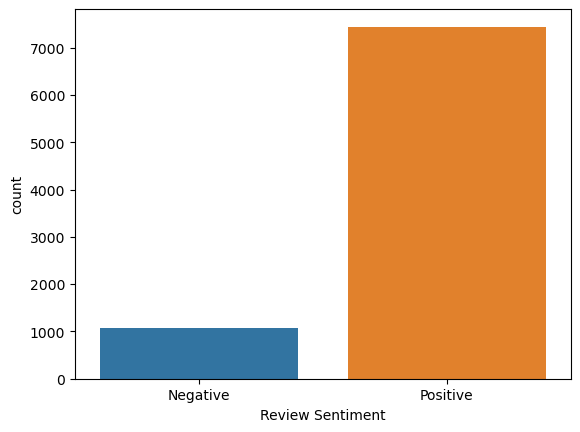

In [29]:
sns.countplot(x='Review Sentiment', data=df1)

<AxesSubplot:ylabel='Review Sentiment'>

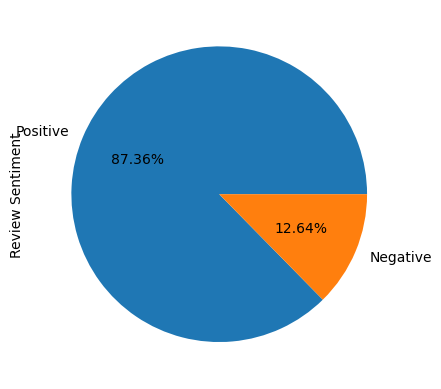

In [30]:
df1['Review Sentiment'].value_counts().plot.pie(autopct='%.2f%%')

In [31]:
df1.columns

Index(['Ratings', 'Reviewer Name', 'Review Title', 'Place of Review',
       'Up Votes', 'Down Votes', 'Month', 'Review text', 'Review Sentiment'],
      dtype='object')

### -: `Identify Input and Output` :-

In [32]:
X = df1[['Review text']]
y = df1['Review Sentiment']

### -: `Splitting the data into train and test` :-

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(X_train.shape, X_test.shape)

(6814, 1) (1704, 1)


In [35]:
X_train.head()

,Review text
6289,superREAD MORE
549,Very slow shuttle. Feels like cheated on quali...
4707,Nice productREAD MORE
764,Wrost and duplicate productDon't buy this sell...
6861,goodREAD MORE


In [36]:
y_train.head()

6289    Positive
549     Negative
4707    Positive
764     Negative
6861    Positive
Name: Review Sentiment, dtype: object

### -: `Data Preprocessing` :-

In [37]:
tqdm.pandas()

In [38]:
## initialise the inbuilt Stemmer
stemmer = PorterStemmer()

In [39]:
## initialise the inbuilt Lemmatizer
lemmatizer = WordNetLemmatizer()

In [40]:
def preprocess(raw_text, flag):
    # Removing special characters and digits
    sentence = re.sub(r"[^A-z0-9 ]", " ", raw_text)
    sentence = re.sub(r"_", " ", raw_text)
    
    # change sentence to lower case
    sentence = sentence.lower()

    # tokenize into words
    tokens = sentence.split()
    
    # remove stop words                
    clean_tokens = [t for t in tokens if not t in stopwords.words("english")]
    
    # Stemming/Lemmatization
    if(flag == 'stem'):
        clean_tokens = [stemmer.stem(word) for word in clean_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]
    
    return pd.Series([" ".join(clean_tokens)])

In [41]:
temp_df = X_train['Review text'].progress_apply(lambda x: preprocess(x, 'stem'))

temp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 6814/6814 [00:39<00:00, 172.23it/s]


,0
6289,superread
549,slow shuttle. feel like cheat qualityread
4707,nice productread
764,wrost duplic productdon't buy seller productfl...
6861,goodread


In [42]:
temp_df.columns = ['clean_review_text_stem']

temp_df.head()

,clean_review_text_stem
6289,superread
549,slow shuttle. feel like cheat qualityread
4707,nice productread
764,wrost duplic productdon't buy seller productfl...
6861,goodread


In [43]:
X_train = pd.concat([X_train, temp_df], axis=1)

X_train.head()

,Review text,clean_review_text_stem
6289,superREAD MORE,superread
549,Very slow shuttle. Feels like cheated on quali...,slow shuttle. feel like cheat qualityread
4707,Nice productREAD MORE,nice productread
764,Wrost and duplicate productDon't buy this sell...,wrost duplic productdon't buy seller productfl...
6861,goodREAD MORE,goodread


In [44]:
temp_df = X_train['Review text'].progress_apply(lambda x: preprocess(x, 'lemma'))

temp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 6814/6814 [00:38<00:00, 178.49it/s]


,0
6289,superread
549,slow shuttle. feel like cheated qualityread
4707,nice productread
764,wrost duplicate productdon't buy seller produc...
6861,goodread


In [45]:
temp_df.columns = ['clean_review_lemma']

temp_df.head()

,clean_review_lemma
6289,superread
549,slow shuttle. feel like cheated qualityread
4707,nice productread
764,wrost duplicate productdon't buy seller produc...
6861,goodread


In [46]:
X_train = pd.concat([X_train, temp_df], axis=1)

X_train.head()

,Review text,clean_review_text_stem,clean_review_lemma
6289,superREAD MORE,superread,superread
549,Very slow shuttle. Feels like cheated on quali...,slow shuttle. feel like cheat qualityread,slow shuttle. feel like cheated qualityread
4707,Nice productREAD MORE,nice productread,nice productread
764,Wrost and duplicate productDon't buy this sell...,wrost duplic productdon't buy seller productfl...,wrost duplicate productdon't buy seller produc...
6861,goodREAD MORE,goodread,goodread


In [47]:
y_train

6289    Positive
549     Negative
4707    Positive
764     Negative
6861    Positive
          ...   
5734    Positive
5191    Positive
5390    Positive
860     Negative
7270    Positive
Name: Review Sentiment, Length: 6814, dtype: object

In [48]:
Positive_df = X_train.loc[y_train=='Positive', :]

Positive_df.head()

,Review text,clean_review_text_stem,clean_review_lemma
6289,superREAD MORE,superread,superread
4707,Nice productREAD MORE,nice productread,nice productread
6861,goodREAD MORE,goodread,goodread
2304,It seems ok by looks. I would rewrite after us...,seem ok looks. would rewrit use whole 2 tube s...,seems ok looks. would rewrite using whole 2 tu...
5849,Best shuttlesREAD MORE,best shuttlesread,best shuttlesread


In [49]:
words = ' '.join(Positive_df['clean_review_lemma'])

print(words[:100])

superread nice productread goodread seems ok looks. would rewrite using whole 2 tube shuttle.read be


In [50]:
Positive_df = X_train.loc[y_train=='Positive', :]

words = ' '.join(Positive_df['clean_review_lemma'])

cleaned_word = " ".join([word for word in words.split() 
                        if 'subject' not in word])

In [51]:
Positive_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

<Figure size 3000x2000 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

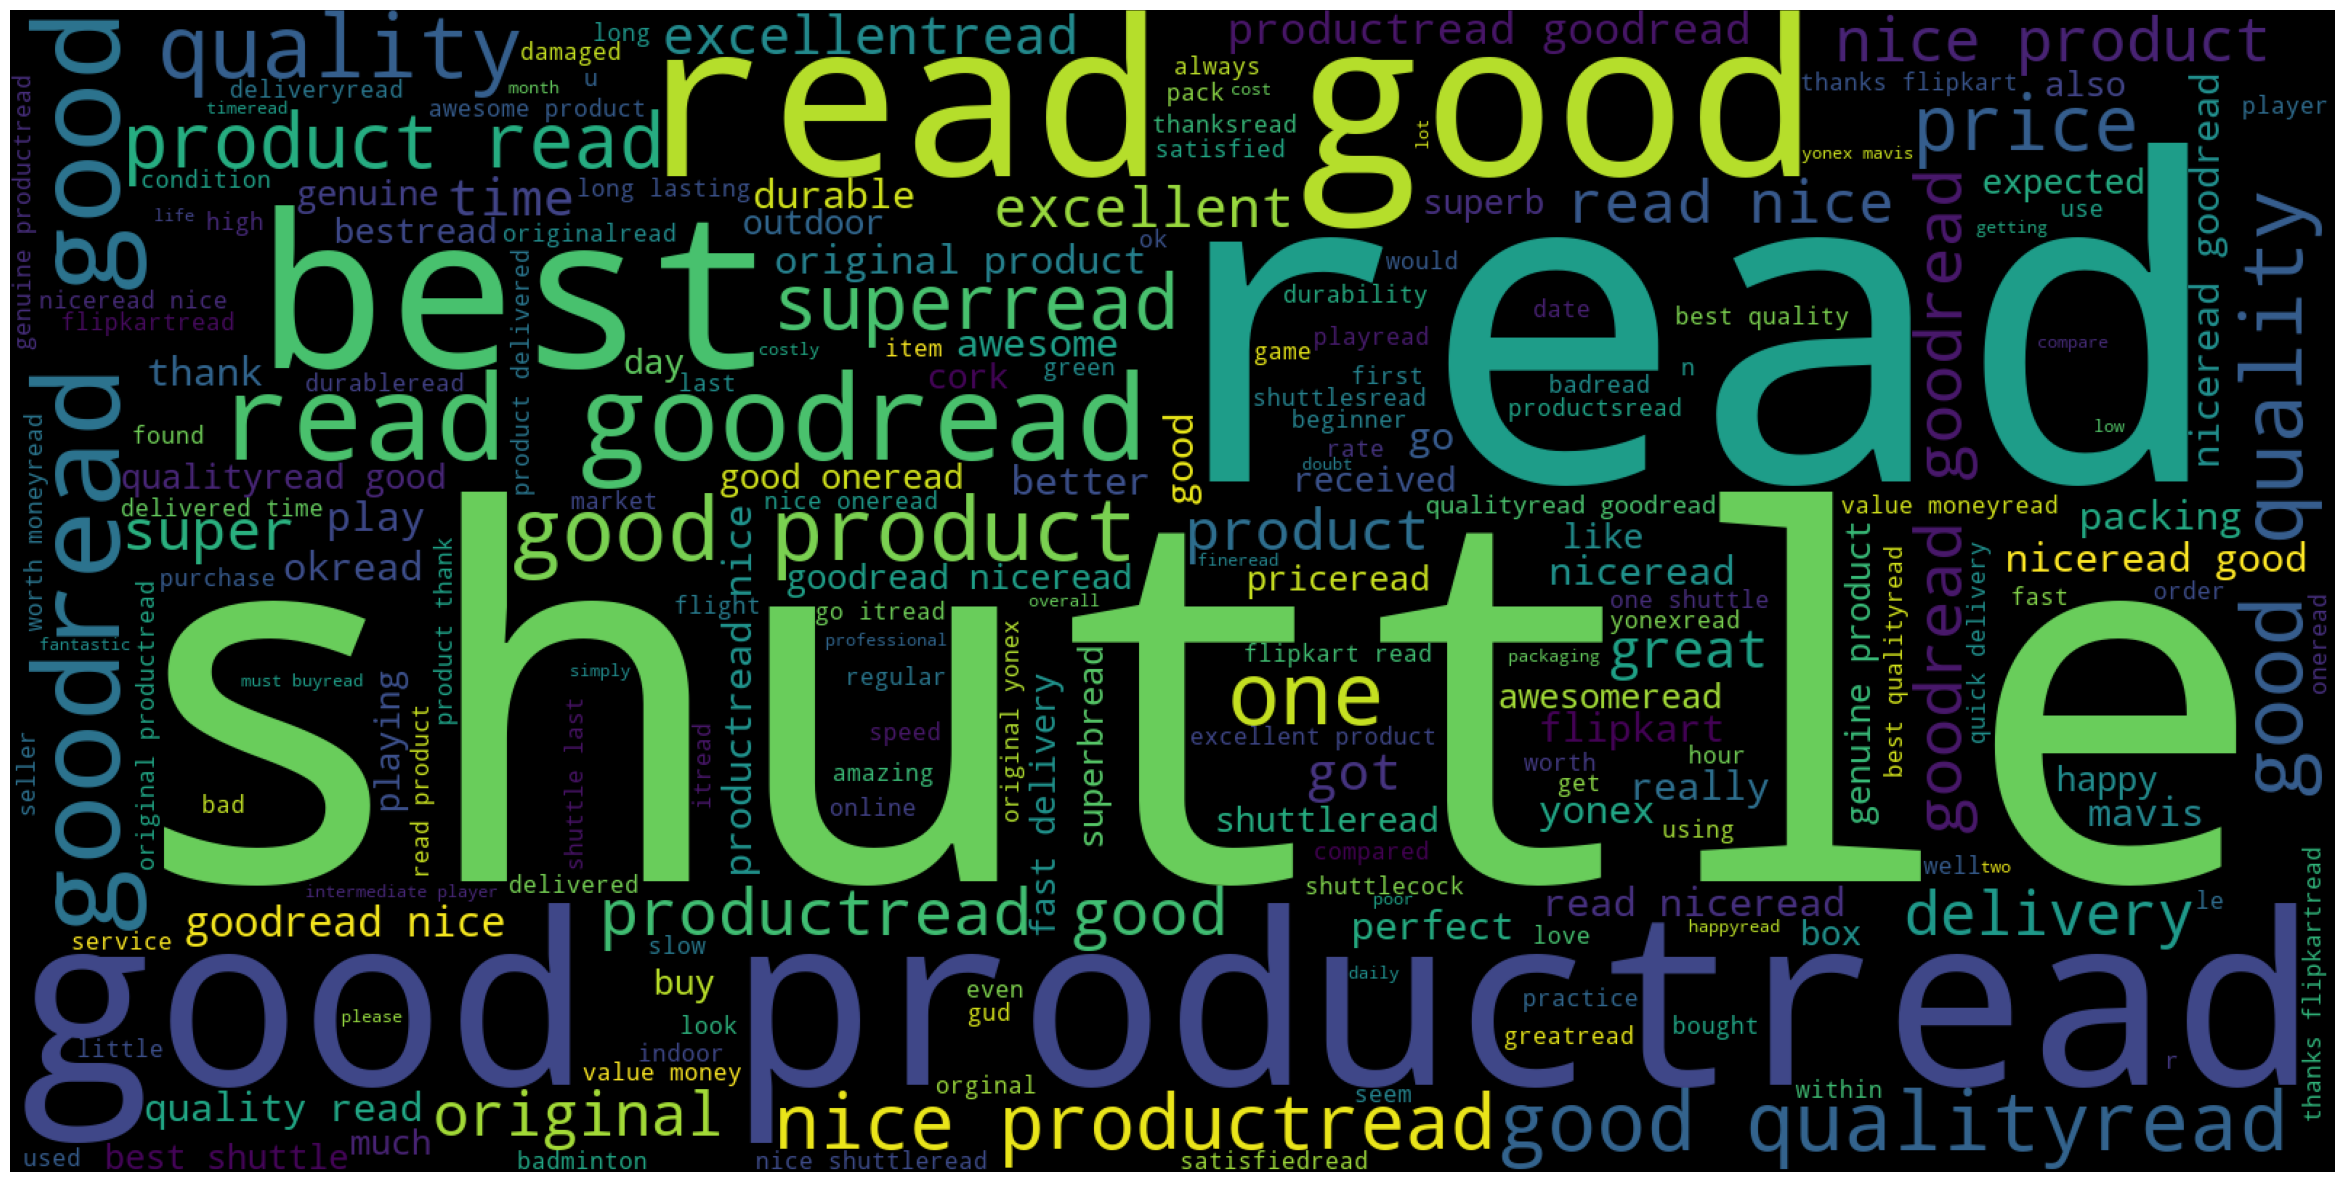

In [52]:
plt.figure(1,figsize=(30,20))
plt.imshow(Positive_wordcloud)
plt.axis('off')
plt.show()

In [53]:
Negative_df = X_train.loc[y_train=='Negative', :]

words = ' '.join(Negative_df['clean_review_lemma'])

cleaned_word = " ".join([word for word in words.split() 
                        if 'subject' not in word])

In [54]:
Negative_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

<Figure size 3000x2000 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

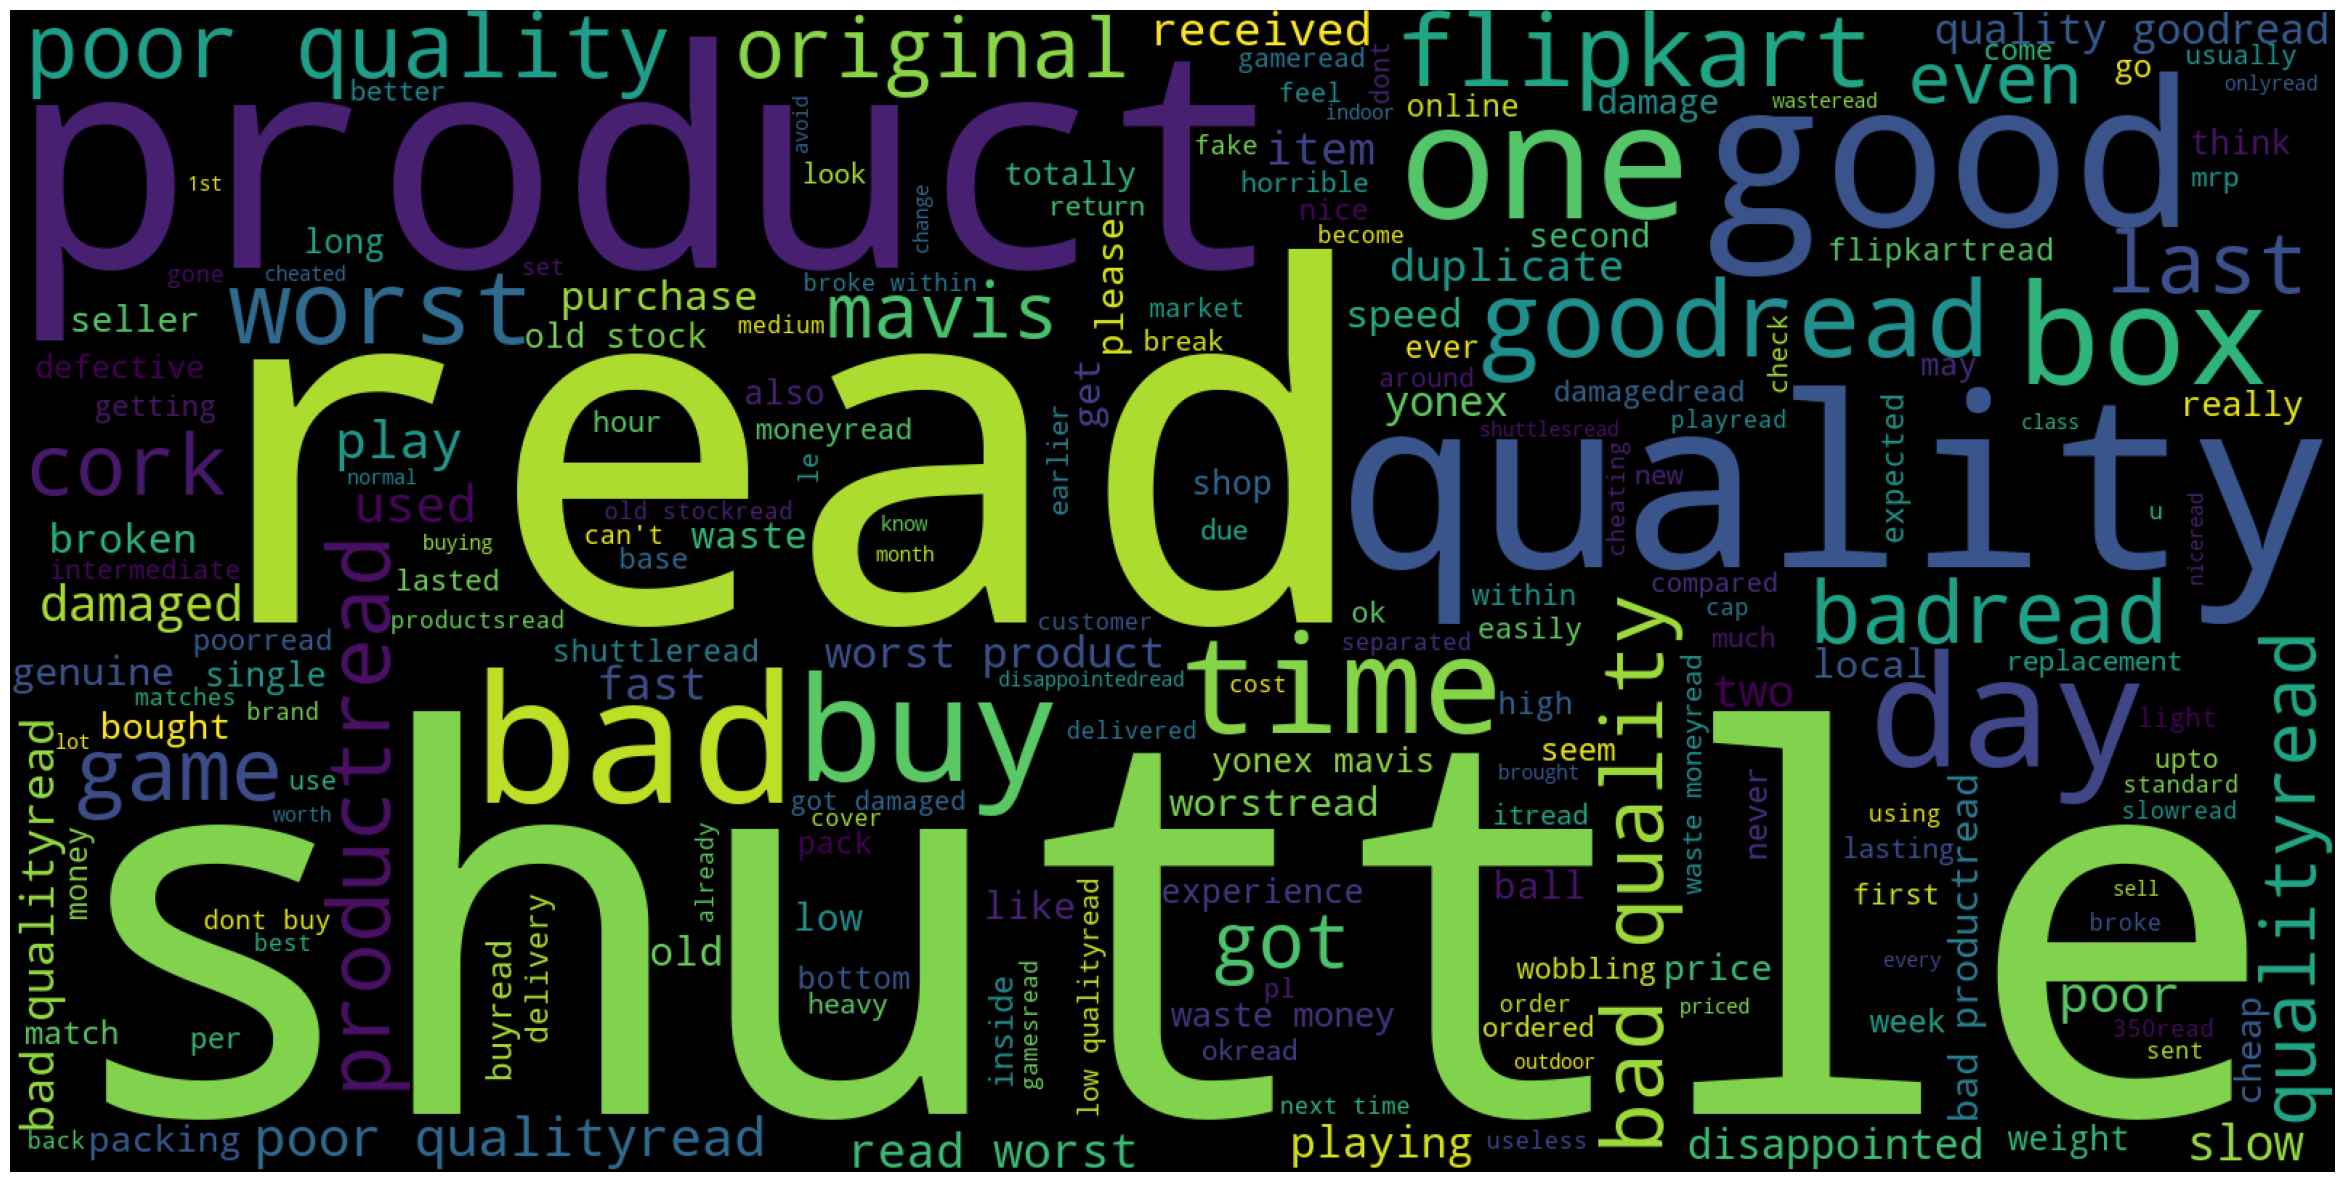

In [55]:
plt.figure(1,figsize=(30,20))
plt.imshow(Negative_wordcloud)
plt.axis('off')
plt.show()

### -: 1. `Converting Text to Numerical vectors` - `BOW Representation` :-

In [56]:
X_train.head()

,Review text,clean_review_text_stem,clean_review_lemma
6289,superREAD MORE,superread,superread
549,Very slow shuttle. Feels like cheated on quali...,slow shuttle. feel like cheat qualityread,slow shuttle. feel like cheated qualityread
4707,Nice productREAD MORE,nice productread,nice productread
764,Wrost and duplicate productDon't buy this sell...,wrost duplic productdon't buy seller productfl...,wrost duplicate productdon't buy seller produc...
6861,goodREAD MORE,goodread,goodread


In [57]:
cv = CountVectorizer()

In [58]:
%time X_train_bow = cv.fit_transform(X_train['clean_review_lemma'])

Wall time: 155 ms


In [59]:
X_train_bow

<6814x2946 sparse matrix of type '<class 'numpy.int64'>'
	with 24620 stored elements in Compressed Sparse Row format>

In [60]:
print("Total unique words:", len(cv.vocabulary_))

print("Type of train features:", type(X_train_bow))

print("Shape of input data:", X_train_bow.shape)

Total unique words: 2946
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (6814, 2946)


In [61]:
print(X_train_bow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [62]:
from sys import getsizeof

print(type(X_train_bow))
print(getsizeof(X_train_bow), "Bytes")

<class 'scipy.sparse._csr.csr_matrix'>
48 Bytes


In [63]:
from sys import getsizeof

print(type(X_train_bow.toarray()))
print(getsizeof(X_train_bow.toarray()), "Bytes")

<class 'numpy.ndarray'>
160592480 Bytes


In [64]:
X_test.head()

,Review text
7497,Happy with this productREAD MORE
5257,GoodREAD MORE
2571,As regular 😇READ MORE
1084,One day 1cap gaanREAD MORE
856,No goodREAD MORE


In [65]:
temp_df = X_test['Review text'].progress_apply(lambda x: preprocess(x, 'lemma'))

temp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 1704/1704 [00:09<00:00, 178.12it/s]


,0
7497,happy productread
5257,goodread
2571,regular 😇read
1084,one day 1cap gaanread
856,goodread


In [66]:
temp_df.columns = ['clean_review_lemma']

temp_df.head()

,clean_review_lemma
7497,happy productread
5257,goodread
2571,regular 😇read
1084,one day 1cap gaanread
856,goodread


In [67]:
X_test = pd.concat([X_test, temp_df], axis=1)

X_test.head()

,Review text,clean_review_lemma
7497,Happy with this productREAD MORE,happy productread
5257,GoodREAD MORE,goodread
2571,As regular 😇READ MORE,regular 😇read
1084,One day 1cap gaanREAD MORE,one day 1cap gaanread
856,No goodREAD MORE,goodread


In [68]:
%time X_test_bow = cv.transform(X_test['clean_review_lemma'])

Wall time: 26.6 ms


### -: `Building a model & Evaluation` :-

### * MultinomialNB

In [69]:
classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

MultinomialNB()

In [70]:
y_test_pred = classifier.predict(X_test_bow)

In [71]:
print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9049295774647887
              precision    recall  f1-score   support

    Negative       0.72      0.48      0.58       231
    Positive       0.92      0.97      0.95      1473

    accuracy                           0.90      1704
   macro avg       0.82      0.73      0.76      1704
weighted avg       0.90      0.90      0.90      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

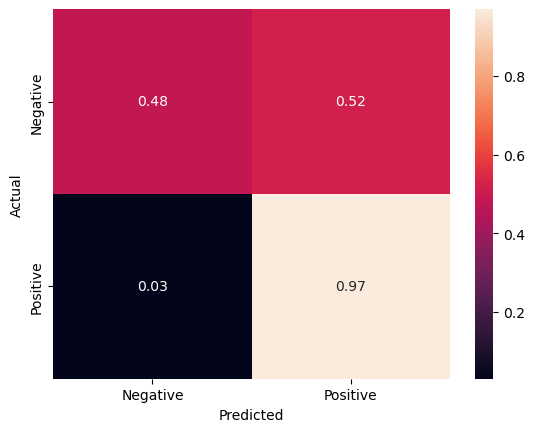

In [72]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### -: `Implementing various Algorithms to find the Best Model` :-

In [74]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
        'vectorization': [CountVectorizer(),TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*" * 10, algo, "*" * 10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='f1',  
                               return_train_score=True,
                               verbose=1)
    grid_search.fit(X_train['clean_review_lemma'], y_train)
    best_models[algo] = grid_search.best_estimator_
#     print('Score on Test Data:', grid_search.score(x_test, y_test, pos_label='Positive'))
    y_pred = grid_search.best_estimator_.predict(X_test['clean_review_lemma'])
    f1 = f1_score(y_test, y_pred, pos_label='Positive')  
    print('F1 Score on Test Data:', f1)

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=.cache\joblib),
                                steps=[('vectorization', CountVectorizer()),
                                       ('classifier', MultinomialNB())]),
             param_grid=[{'classifier__alpha': [1, 10],
                          'vectorization': [CountVectorizer(max_features=1000)],
                          'vectorization__max_features': [1000, 1500, 2000,
                                                          5000]}],
             return_train_score=True, scoring='f1', verbose=1)

F1 Score on Test Data: 0.945927903871829
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=.cache\joblib),
                                steps=[('vectorization', CountVectorizer()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid=[{'classifier__max_depth': [None, 5, 10],
                          'vectorization': [CountVectorizer(max_features=1000),
                                            TfidfVectorizer()],
                          'vectorization__max_features': [1000, 1500, 2000,
                                                          5000]}],
             return_train_score=True, scoring='f1', verbose=1)

F1 Score on Test Data: 0.9344537815126052
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=.cache\joblib),
                                steps=[('vectorization', CountVectorizer()),
                                       ('classifier', LogisticRegression())]),
             param_grid=[{'classifier__C': [0.1, 1, 10],
                          'classifier__class_weight': ['balanced'],
                          'classifier__l1_ratio': [0.4, 0.5, 0.6],
                          'classifier__penalty': ['elasticnet'],
                          'classifier__solver': ['saga'],
                          'vectorization': [CountVectorizer(max_features=1000),
                                            TfidfVectorizer()],
                          'vectorization__max_features': [1000, 1500, 2000,
                                                          5000]}],
             return_train_score=True, scoring='f1', verbose=1)

F1 Score on Test Data: 0.928794720389024


In [75]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier', DecisionTreeClassifier())])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.4, penalty='elasticnet',
                                    solver='saga'))])



In [76]:
for name, model in best_models.items():
    print("*" * 15, name, "*" * 15)
    
    joblib.dump(model, f'model/{name}.pkl')
    loaded_model = joblib.load(f'model/{name}.pkl')
    
    %time y_test_pred = loaded_model.predict(X_test['clean_review_lemma'])

    f1 = f1_score(y_test, y_test_pred, pos_label='Positive')

    print("F1 Score (Positive Class):", f1)
    print("Model Size:", os.path.getsize(f'model/{name}.pkl'), "Bytes")

*************** naive_bayes ***************


['model/naive_bayes.pkl']

Wall time: 23.2 ms
F1 Score (Positive Class): 0.945927903871829
Model Size: 84610 Bytes
*************** decision_tree ***************


['model/decision_tree.pkl']

Wall time: 16.4 ms
F1 Score (Positive Class): 0.9344537815126052
Model Size: 222248 Bytes
*************** logistic_regression ***************


['model/logistic_regression.pkl']

Wall time: 16.2 ms
F1 Score (Positive Class): 0.928794720389024
Model Size: 60868 Bytes
